# House Price Prediction using XGBoost
## Individual Project
### Data Mining -EC 9560
#### 2021/E/045




In [1]:

!pip install -r requirements.txt


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import covariance, median
from sympy import false


### Import Dataset

In [3]:
datasetPath='./raw/realestate_data_southcarolina_2025.csv'
df=pd.read_csv(datasetPath)
df.head()

,type,sub_type,sqft,baths,beds,stories,year_built,listPrice
0,condos,condo,1268.0,2.0,3.0,1.0,2002.0,199900.0
1,condos,condo,969.0,2.0,2.0,7.0,1985.0,119900.0
2,single_family,NaN,2181.0,3.0,3.0,2.0,NaN,100000.0
3,single_family,NaN,2083.0,2.0,3.0,NaN,1983.0,309900.0
4,land,NaN,NaN,0.0,NaN,NaN,NaN,1000.0


In [4]:

target_col = "listPrice"
df.targetColumn = target_col
y = df[target_col]
X = df.drop(columns=[target_col])


### Basic information


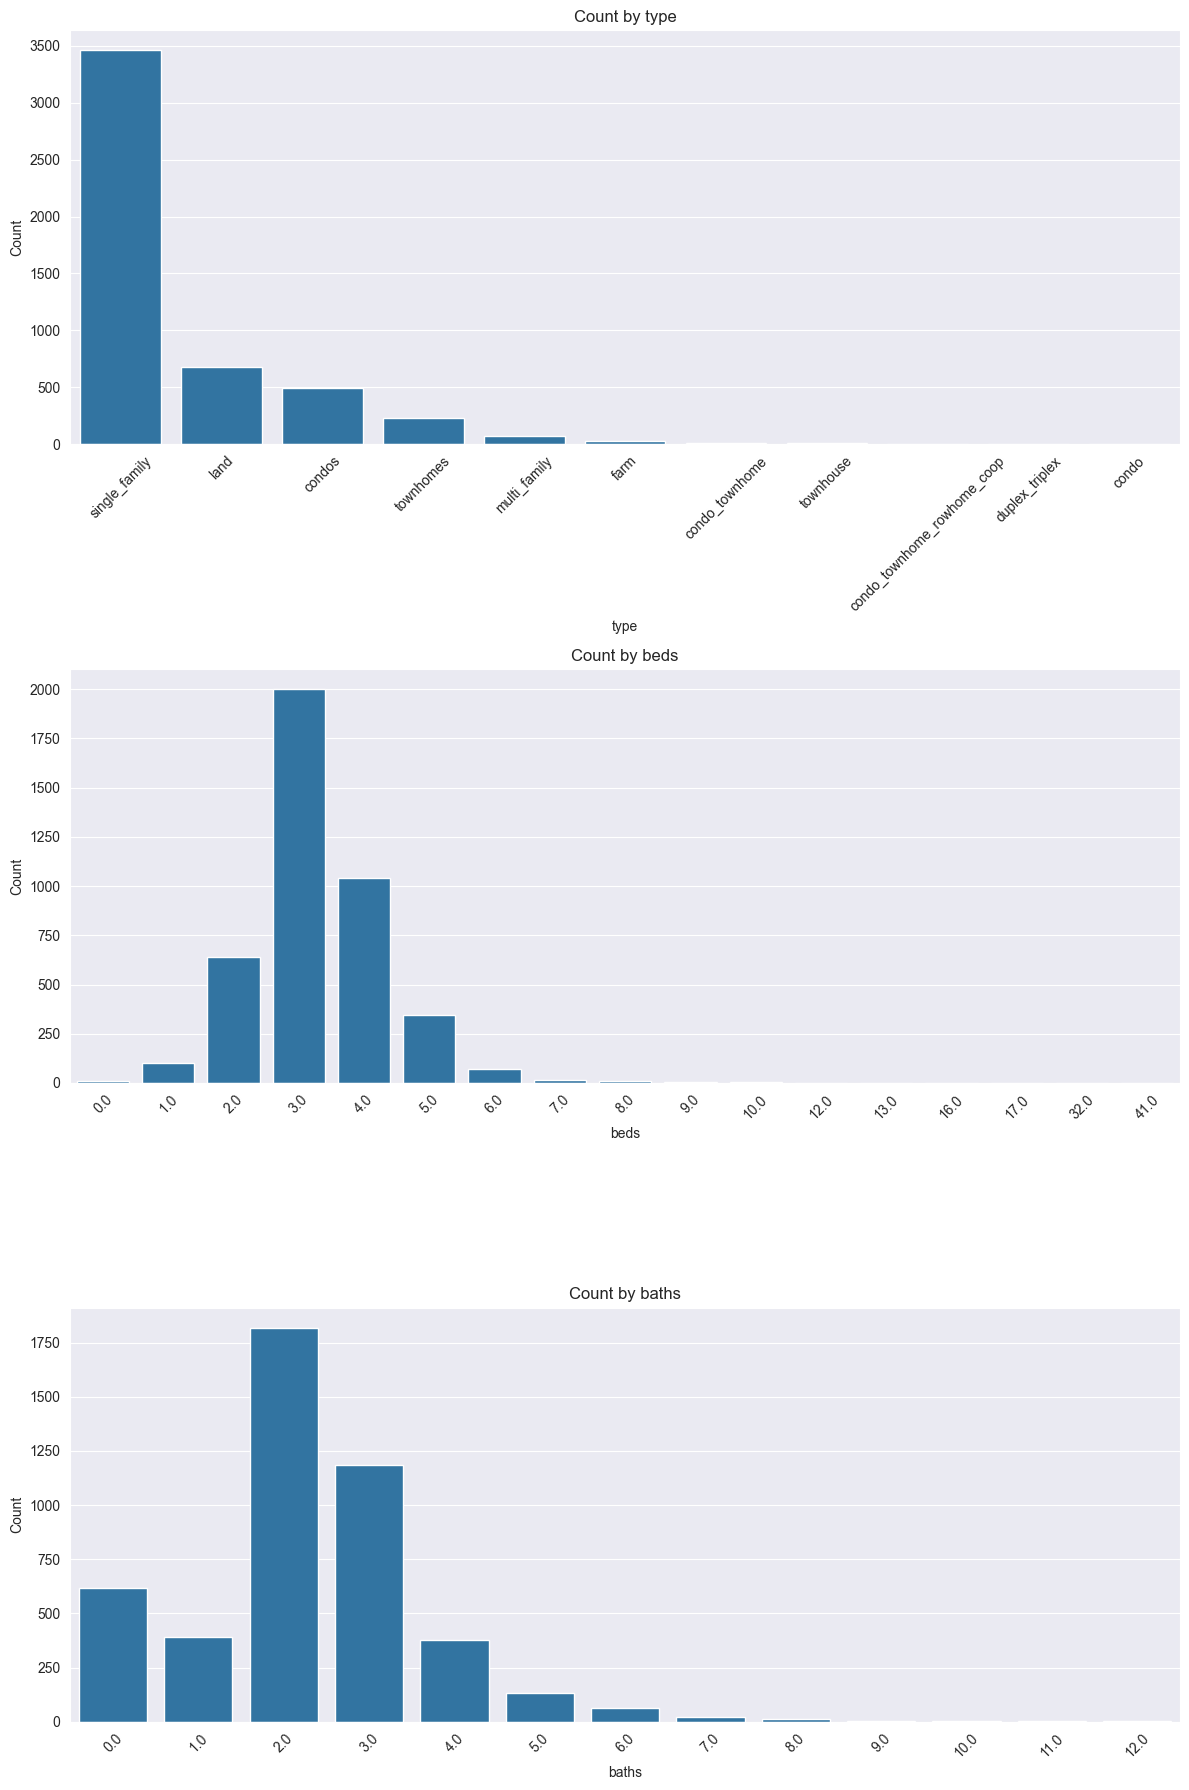

In [5]:

cat_cols = ['type','beds','baths']
plt.figure(figsize=(12,18))
for i, col in enumerate(cat_cols):
    plt.subplot(len(cat_cols), 1, i+1)
    sns.barplot(x=df[col].value_counts().index, y=df[col].value_counts().values)
    plt.title(f'Count by {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

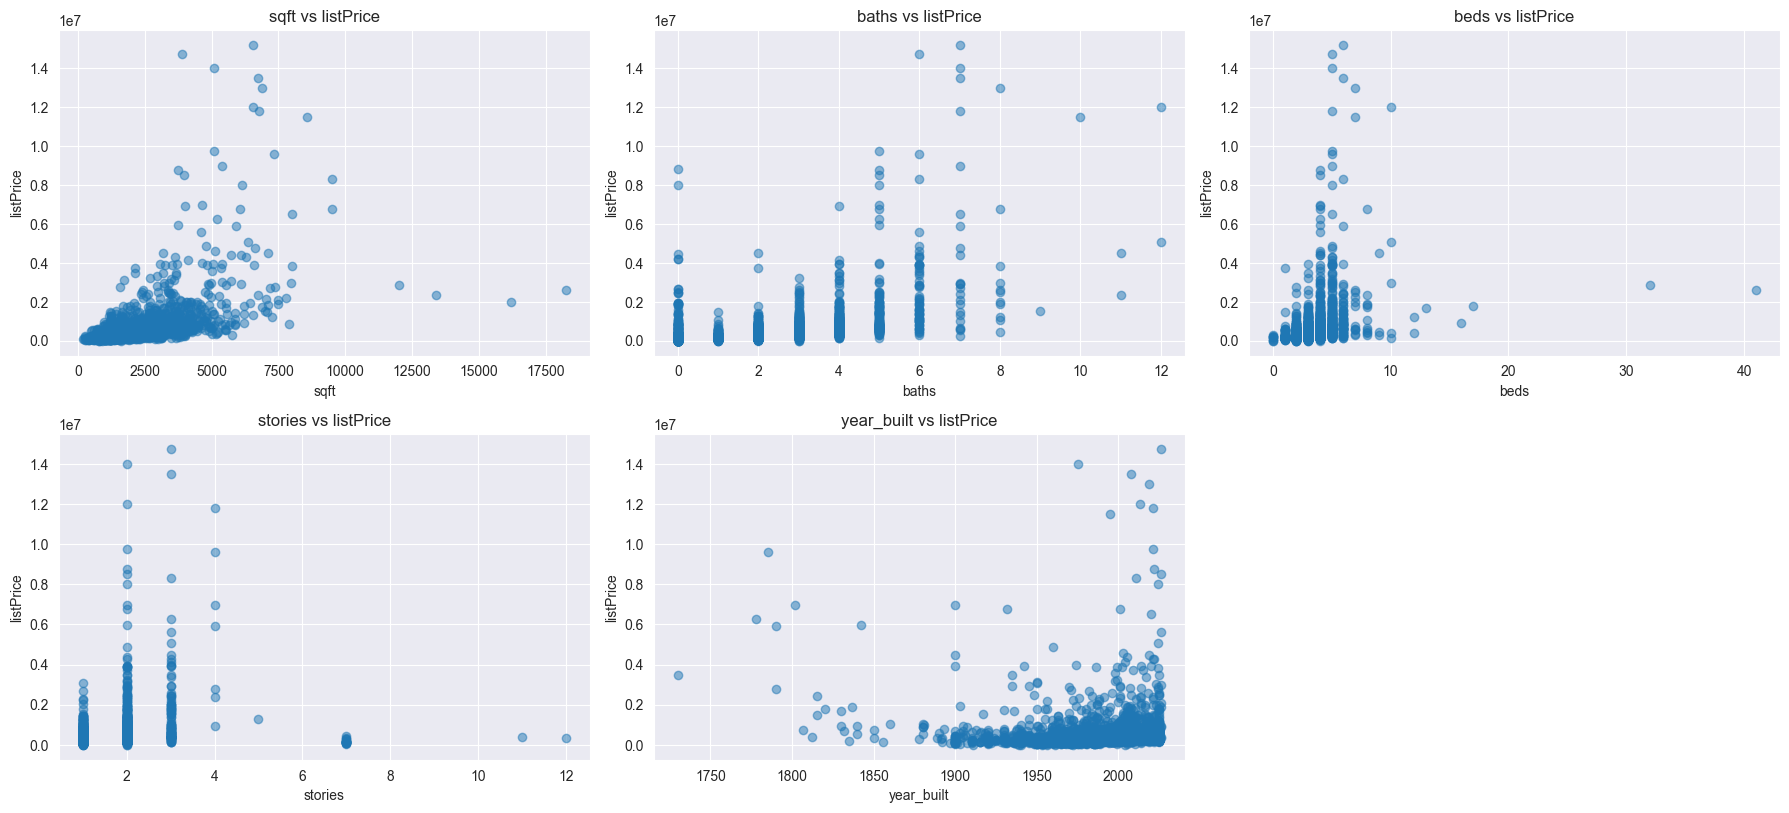

In [6]:
numeric_cols = [col for col in df.select_dtypes(include=['int64','float64']).columns if col!=target_col]
n_cols =3
n_rows =(len(numeric_cols) + n_cols - 1)

plt.figure(figsize=(6*n_cols,4 *n_rows))
for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows,n_cols,i + 1)
    plt.scatter(df[col],df[target_col], alpha=0.5)
    plt.xlabel(col)
    plt.ylabel(target_col)
    plt.title(f'{col} vs {target_col}')
plt.tight_layout()
plt.show()

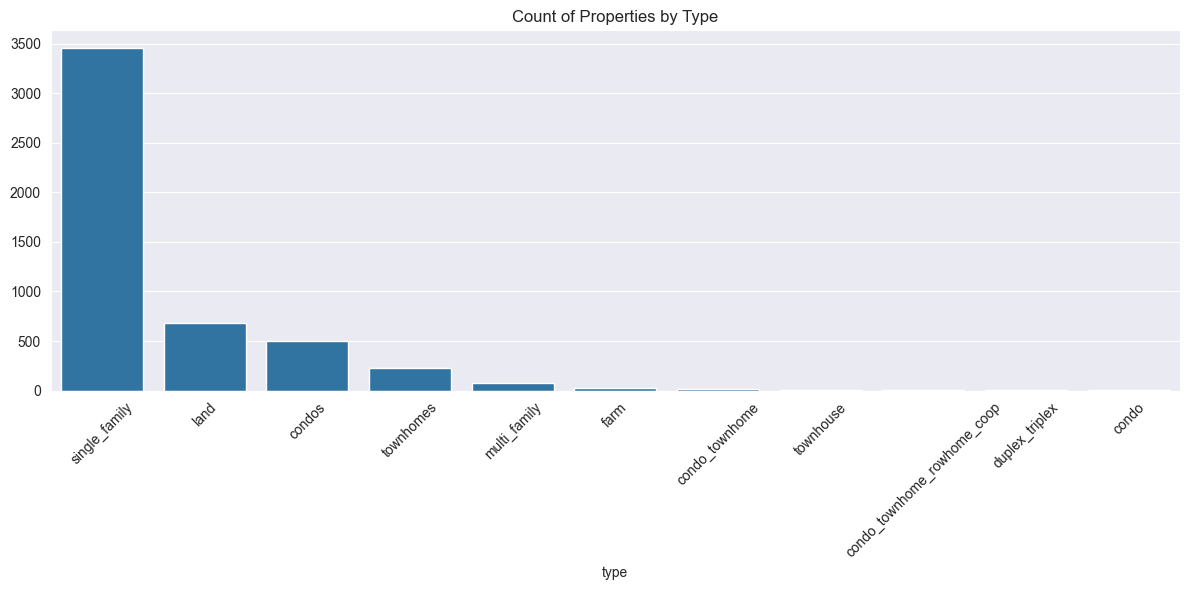

In [7]:
plt.figure(figsize=(12, 6))
sns.barplot(x=df['type'].value_counts().index,
            y=df['type'].value_counts().values)
plt.title('Count of Properties by Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



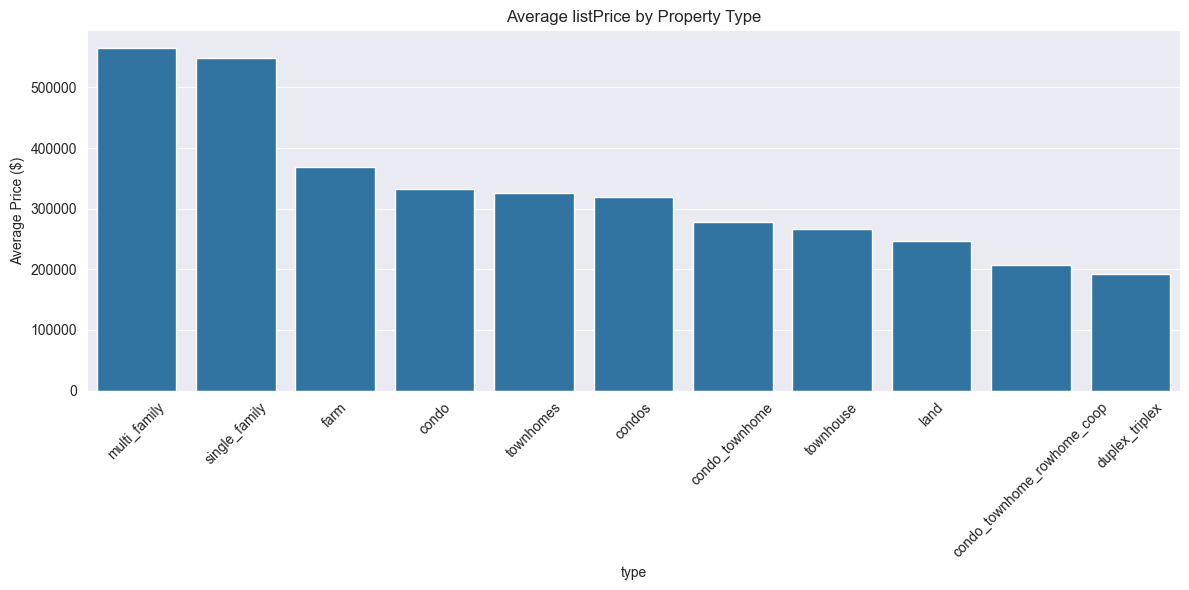

In [8]:
plt.figure(figsize=(12, 6))
avg_price =df.groupby('type')[target_col].mean().sort_values(ascending=False)
sns.barplot(x=avg_price.index, y=avg_price.values)
plt.title(f'Average {target_col} by Property Type')
plt.xticks(rotation=45)
plt.ylabel('Average Price ($)')
plt.tight_layout()
plt.show()


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   type        4998 non-null   object 
 1   sub_type    669 non-null    object 
 2   sqft        4197 non-null   float64
 3   baths       4623 non-null   float64
 4   beds        4250 non-null   float64
 5   stories     3520 non-null   float64
 6   year_built  3379 non-null   float64
 7   listPrice   4973 non-null   float64
dtypes: float64(6), object(2)
memory usage: 312.7+ KB


In [10]:
df.describe()

,sqft,baths,beds,stories,year_built,listPrice
count,4197.000000,4623.000000,4250.000000,3520.000000,3379.000000,4.973000e+03
mean,1997.527043,2.256760,3.316706,1.532386,1988.816514,4.718185e+05
std,1098.871065,1.385171,1.329439,0.740250,30.930078,8.280672e+05
min,182.000000,0.000000,0.000000,1.000000,1730.000000,1.000000e+00
25%,1320.000000,2.000000,3.000000,1.000000,1973.000000,1.999000e+05
50%,1727.000000,2.000000,3.000000,1.000000,1994.000000,3.054000e+05
75%,2400.000000,3.000000,4.000000,2.000000,2010.000000,4.790000e+05
max,18250.000000,12.000000,41.000000,12.000000,2026.000000,1.520000e+07


### Correlation Matrix

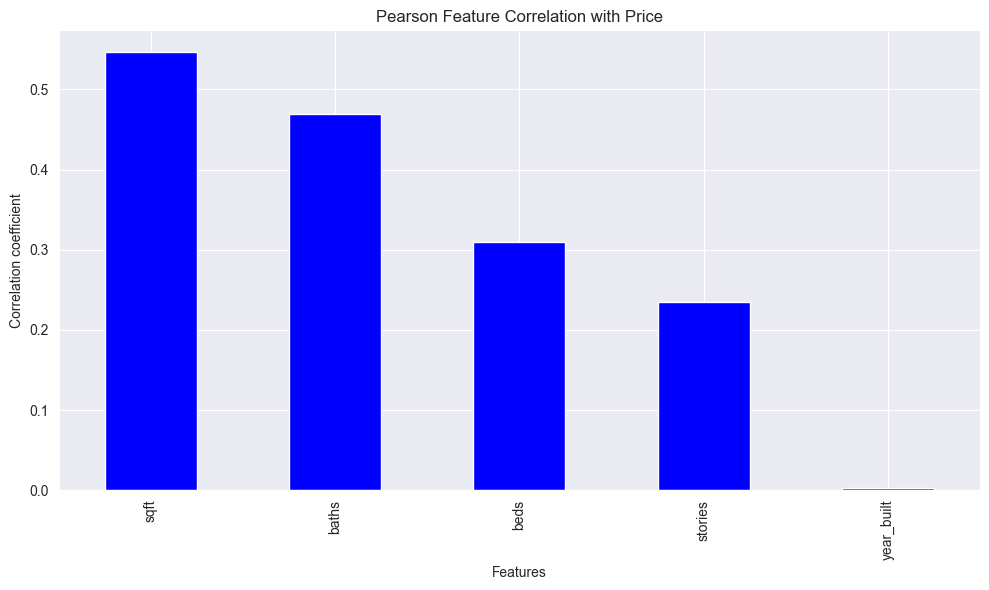

In [11]:

corr_matrix = df.corr(method='pearson',numeric_only=True)

price_corr = corr_matrix[target_col].drop(target_col).sort_values(ascending=False)

plt.figure(figsize=(10,6))
price_corr.plot(kind='bar',color='blue')
plt.title('Pearson Feature Correlation with Price')
plt.ylabel('Correlation coefficient')
plt.xlabel('Features')
plt.tight_layout()
plt.show()

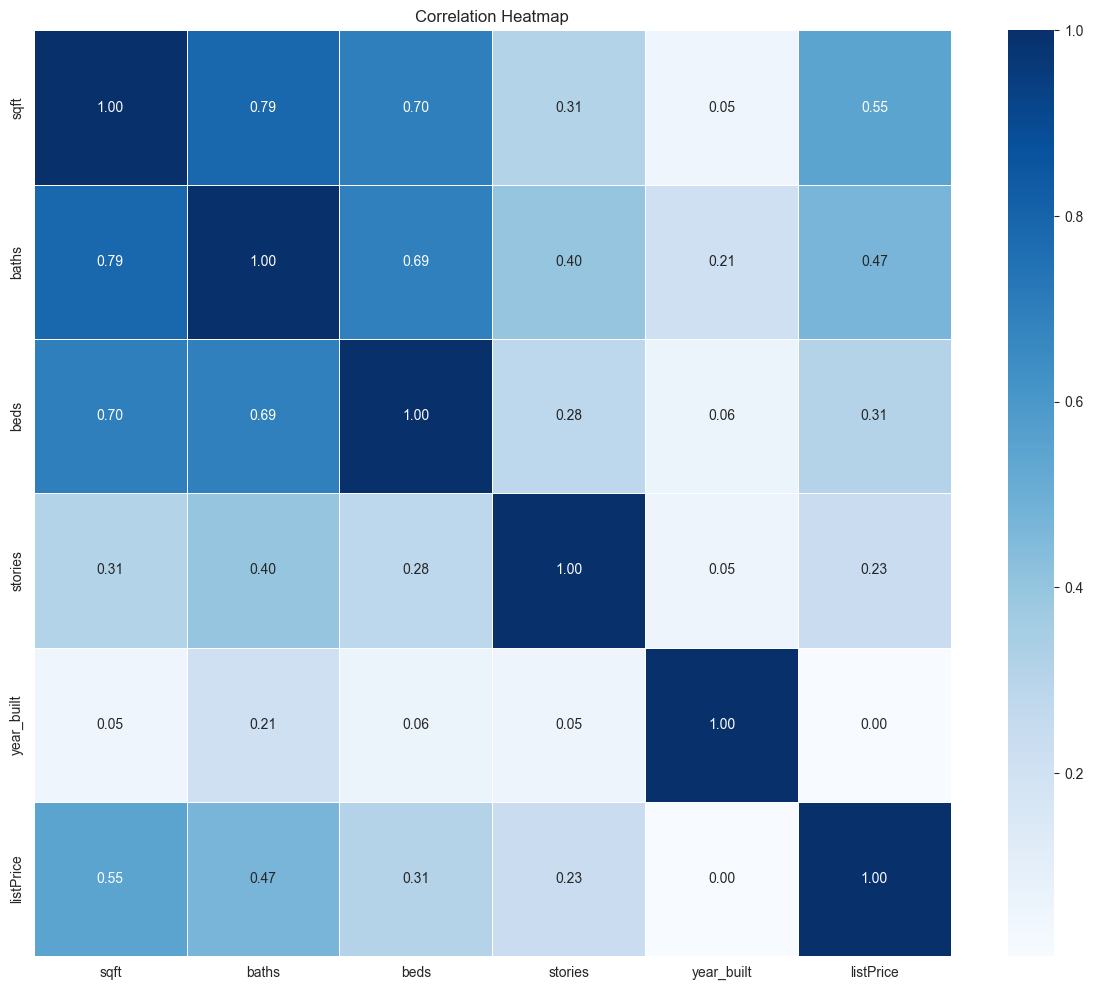

In [12]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix,annot=True,cmap='Blues',fmt='.2f',linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

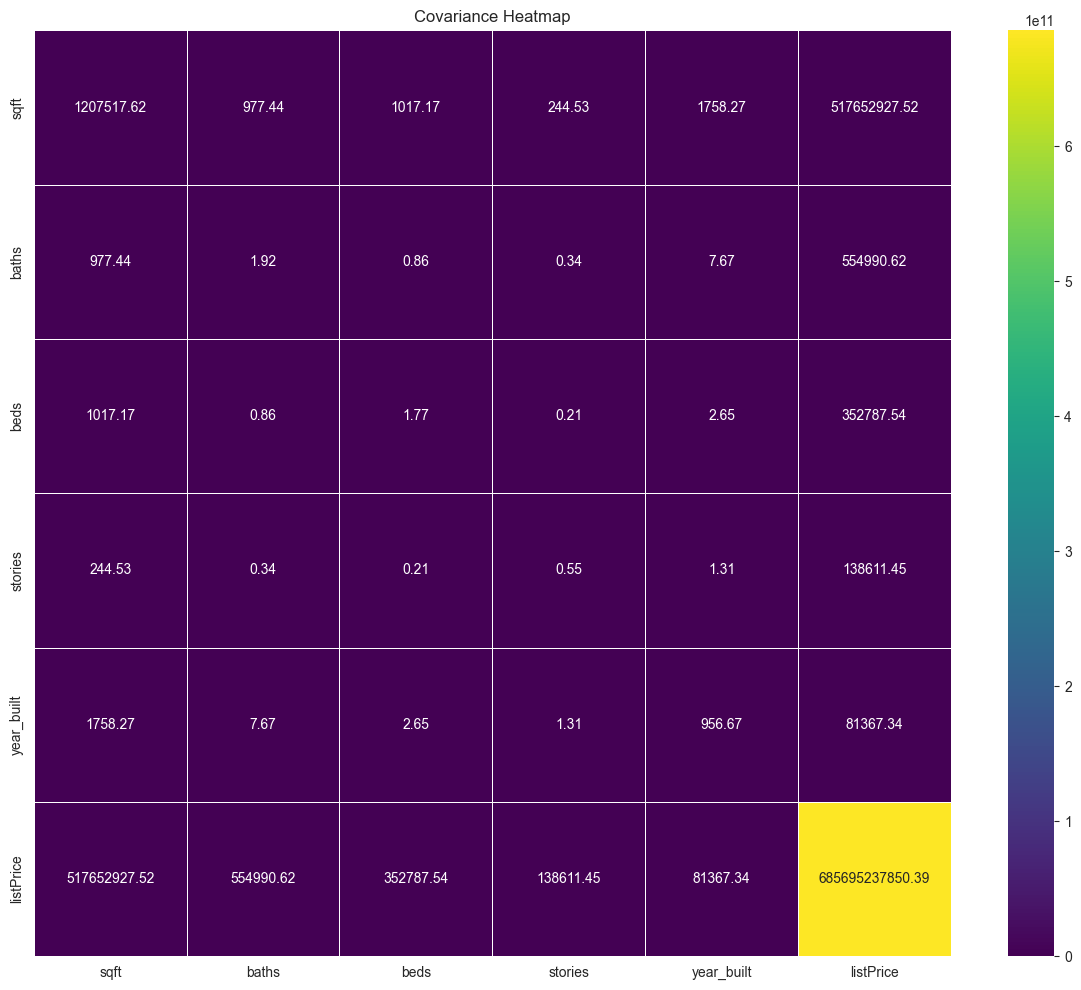

In [13]:
cov_matrix = df.cov(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(cov_matrix,annot=True,cmap='viridis',fmt='.2f',linewidths=0.5)
plt.title('Covariance Heatmap')
plt.tight_layout()
plt.show()

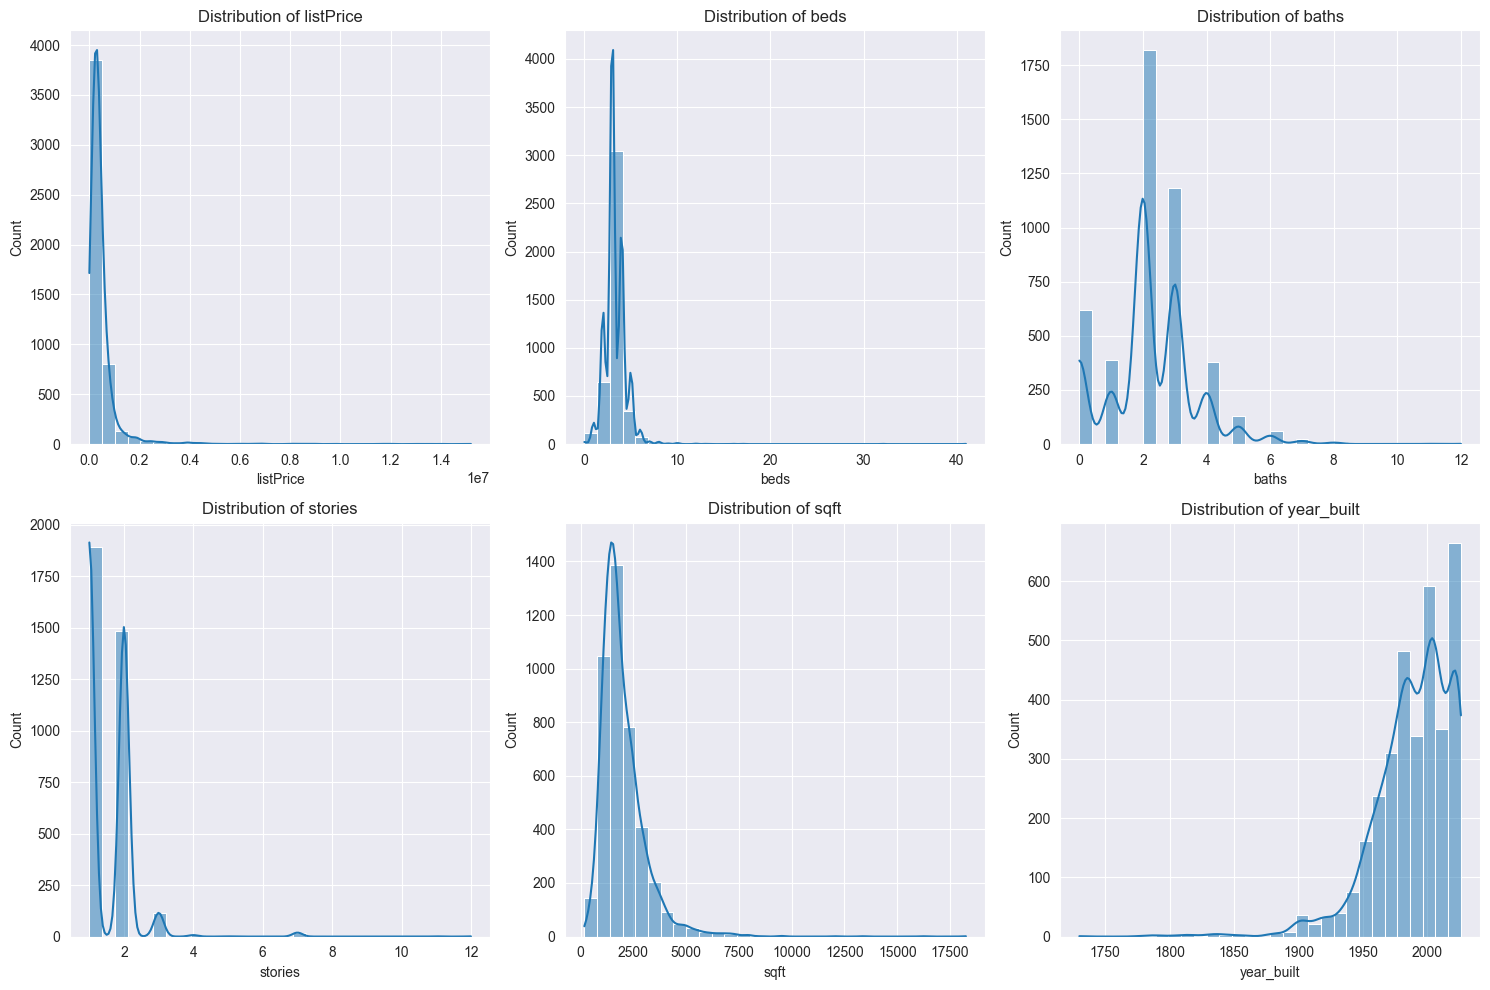

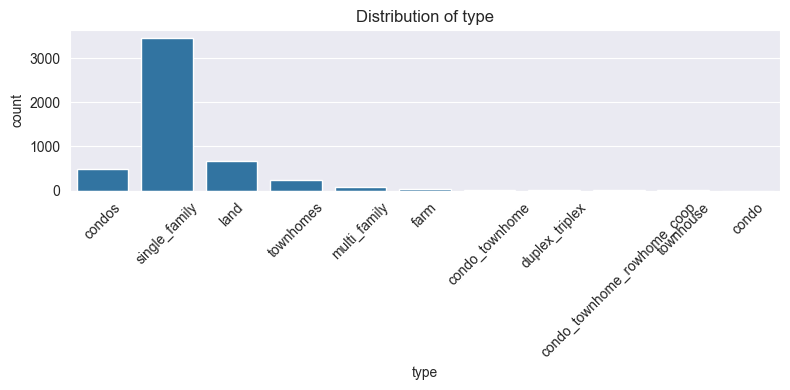

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Numeric columns
numeric_cols = ['listPrice', 'beds', 'baths', 'stories', 'sqft', 'year_built']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Categorical column
plt.figure(figsize=(8, 4))
sns.countplot(x='type', data=df)
plt.title('Distribution of type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Number of outliers using z-score method: 241


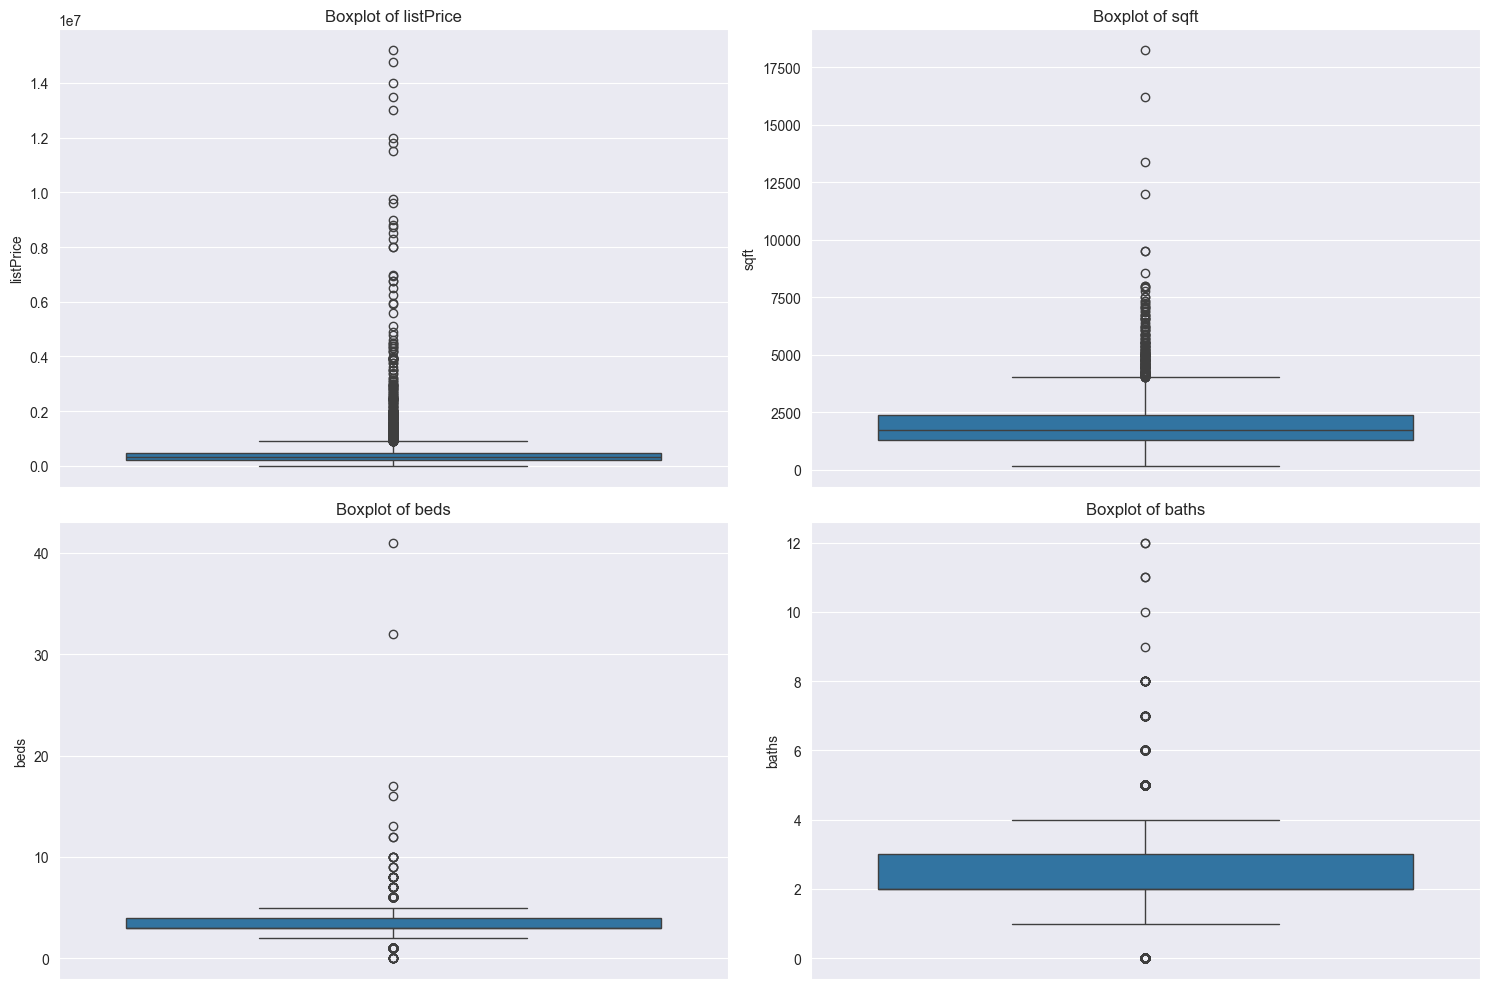

In [15]:
from scipy import stats
numeric_df =df.select_dtypes(include=['int64','float64'])
numeric_df_filled = numeric_df.fillna(numeric_df.mean())
z_scores =stats.zscore(numeric_df_filled)
abs_z_scores= abs(z_scores)
z_outliers =(abs_z_scores >3).any(axis=1)
outliers_z =df[z_outliers]
print(f"Number of outliers using z-score method: {len(outliers_z)}")

plt.figure(figsize=(15,10))
for i, col in enumerate(['listPrice','sqft','beds','baths'][:4]):
    plt.subplot(2,2,i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

## Lab 03

### Data Preprocessing

#### Filling Missing Values

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   type        4998 non-null   object 
 1   sub_type    669 non-null    object 
 2   sqft        4197 non-null   float64
 3   baths       4623 non-null   float64
 4   beds        4250 non-null   float64
 5   stories     3520 non-null   float64
 6   year_built  3379 non-null   float64
 7   listPrice   4973 non-null   float64
dtypes: float64(6), object(2)
memory usage: 312.7+ KB


In [17]:
df.isnull().sum()

type             3
sub_type      4332
sqft           804
baths          378
beds           751
stories       1481
year_built    1622
listPrice       28
dtype: int64

the land values were not considered for this analysis as they do not have the features like beds, baths, sqft, stories etc. which are important for predicting house prices.and they carry very little information about their prices

In [18]:
# Remove rows where type is 'land'
df = df[df['type'] != 'land'].reset_index(drop=True)
print(f"Rows after removing 'land' type: {df.shape[0]}")

Rows after removing 'land' type: 4319


In [19]:
# Assign numeric labels to each type
type_mapping = {
    'single_family': 0,
    'condos': 1,
    'townhomes': 2,
    'multi_family': 3,
    'farm': 4
}

df['type_encoded'] = df['type'].map(type_mapping)

# Check the result
print(df[['type', 'type_encoded']].head())
df['type']=df['type_encoded']
df.drop(columns='type_encoded',axis=1,inplace=True)

            type  type_encoded
0         condos           1.0
1         condos           1.0
2  single_family           0.0
3  single_family           0.0
4  single_family           0.0


In [20]:
# Remove rows with missing listPrice values
df = df.dropna(subset=['listPrice']).reset_index(drop=True)
print(f"Rows after removing missing listPrice: {df.shape[0]}")

Rows after removing missing listPrice: 4291


### Fill the missing values in 'baths', 'beds', 'stories', and 'sqft' columns using the median

as the distributions of these columns are right-skewed, the median is a better measure of central tendency than the mean.

In [21]:
# Fill missing values in 'baths' and 'beds' with their median
df['baths'] = df['baths'].fillna(df['baths'].median())
df['beds'] = df['beds'].fillna(df['beds'].median())
df['type']=df['type'].fillna(df['type'].median())
df['stories']=df['stories'].fillna(df['stories'].median())
df['sqft'] = df['sqft'].fillna(df['sqft'].mean())

In [22]:
# Calculate the median of the 'yearBuilt' column
median_year_built = df['year_built'].median()
print(f"Median year built: {median_year_built}")

Median year built: 1994.0


In [23]:
df.drop(columns='sub_type',axis=1,inplace=True)

### Predict missing 'year_built' values using RandomForestRegressor

as the most of the columns has not missing values those columns can be used as features to predict the missing values of 'year_built'

In [24]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

df_encoded = pd.get_dummies(df, columns=['type'])

features = ['listPrice', 'beds', 'baths', 'sqft', 'stories'] + [col for col in df_encoded.columns if col.startswith('type_')]

train_df = df_encoded[df_encoded['year_built'].notna()]
predict_df = df_encoded[df_encoded['year_built'].isna()]


X_train = train_df[features]
y_train = train_df['year_built']
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

X_predict = predict_df[features]
predicted_years = model.predict(X_predict)
print(f"Predicted years: {predicted_years}")

df.loc[df['year_built'].isna(), 'year_built'] = predicted_years

Predicted years: [1940.21       1950.54       1937.69       1961.57       1982.73
 2016.02       1947.87       1980.37       1985.01       1957.25
 1948.05       2009.07       2015.66       1964.45       2005.97
 1990.49       1967.12       1991.19       1959.15       2000.09
 2000.74       1997.61       2001.23       1958.22       1965.33
 1937.51       2008.99       1999.42       2004.02       2000.34
 1986.2        1991.51       1997.47       1989.09       1993.71
 1982.22       1987.36       1996.9        1978.76       2002.92
 1987.73       1994.48       1991.7        1991.24       1995.22
 1984.4        2000.6        1969.83       2007.24       2011.51
 1996.2        1975.47       2001.61       1994.62       1993.99
 1993.38       1993.56666667 2007.56       2010.42       2006.94
 2000.08       2005.72       1995.74       1945.12       2001.51
 1989.01       1998.87       1947.6        1952.12       1982.13
 2001.04       2002.38       1972.9        1998.9        2014.6
 1951.42 

In [25]:
df.isnull().sum()

type          0
sqft          0
baths         0
beds          0
stories       0
year_built    0
listPrice     0
dtype: int64

In [26]:
df.head(26)

,type,sqft,baths,beds,stories,year_built,listPrice
0,1.0,1268.0,2.0,3.0,1.0,2002.00,199900.0
1,1.0,969.0,2.0,2.0,7.0,1985.00,119900.0
2,0.0,2181.0,3.0,3.0,2.0,1940.21,100000.0
3,0.0,2083.0,2.0,3.0,1.0,1983.00,309900.0
4,0.0,1200.0,1.0,3.0,1.0,1950.54,63000.0
5,0.0,1104.0,2.0,2.0,1.0,1974.00,79900.0
6,0.0,1236.0,2.0,3.0,2.0,1937.69,50000.0
7,0.0,1564.0,3.0,3.0,2.0,1989.00,705000.0
8,0.0,774.0,1.0,2.0,1.0,1940.00,5000.0
9,0.0,920.0,1.0,3.0,1.0,1953.00,168000.0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4291 entries, 0 to 4290
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   type        4291 non-null   float64
 1   sqft        4291 non-null   float64
 2   baths       4291 non-null   float64
 3   beds        4291 non-null   float64
 4   stories     4291 non-null   float64
 5   year_built  4291 non-null   float64
 6   listPrice   4291 non-null   float64
dtypes: float64(7)
memory usage: 234.8 KB


### remove duplicates


In [29]:
print(df.duplicated().sum())

duplicate_removed_df = df.drop_duplicates().reset_index(drop=True)


23


In [30]:
duplicate_removed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4268 entries, 0 to 4267
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   type        4268 non-null   float64
 1   sqft        4268 non-null   float64
 2   baths       4268 non-null   float64
 3   beds        4268 non-null   float64
 4   stories     4268 non-null   float64
 5   year_built  4268 non-null   float64
 6   listPrice   4268 non-null   float64
dtypes: float64(7)
memory usage: 233.5 KB
